# Demonstrate xarray.Image operations

In [1]:
import astropy.units as u
import numpy
import xarray
from astropy.coordinates import SkyCoord

from rascil.data_models import PolarisationFrame
from rascil.processing_components.simulation.testing_support import create_test_image

Create  suitable test image

In [2]:
frequency = numpy.linspace(1.0e8, 1.1e8, 8)
phasecentre = SkyCoord(ra=+180.0 * u.deg, dec=-35.0 * u.deg, frame='icrs', equinox='J2000')

ximg = create_test_image(cellsize=0.001, phasecentre=phasecentre, frequency=frequency,
                         polarisation_frame=PolarisationFrame("stokesIQUV"))

assert ximg["pixels"].max() > 0.0

print(ximg)

<xarray.Image>
Dimensions:       (frequency: 8, polarisation: 4, x: 256, y: 256)
Coordinates:
  * frequency     (frequency) float64 1e+08 1.014e+08 ... 1.086e+08 1.1e+08
  * polarisation  (polarisation) <U1 'I' 'Q' 'U' 'V'
  * y             (y) float64 -0.7389 -0.7379 -0.7369 ... -0.4849 -0.4839
  * x             (x) float64 3.014 3.015 3.016 3.017 ... 3.267 3.268 3.269
    ra            (x, y) float64 3.315 3.313 3.312 3.311 ... 3.0 2.999 2.998
    dec           (x, y) float64 -0.7328 -0.7329 -0.733 ... -0.4783 -0.4782
Data variables:
    pixels        (frequency, polarisation, y, x) float64 0.0 0.0 ... 0.0 0.0
Attributes:
    rascil_data_model:    Image
    _polarisation_frame:  stokesIQUV
    _projection:          ('RA---SIN', 'DEC--SIN')
    spectral_type:        FREQ


Show channel 0, stokes I image

In [3]:
import matplotlib.pyplot as plt
ximg2d = ximg.sel({"frequency": frequency[0], "polarisation": "I"})
print(ximg2d)

<xarray.Image>
Dimensions:       (x: 256, y: 256)
Coordinates:
    frequency     float64 1e+08
    polarisation  <U1 'I'
  * y             (y) float64 -0.7389 -0.7379 -0.7369 ... -0.4849 -0.4839
  * x             (x) float64 3.014 3.015 3.016 3.017 ... 3.267 3.268 3.269
    ra            (x, y) float64 3.315 3.313 3.312 3.311 ... 3.0 2.999 2.998
    dec           (x, y) float64 -0.7328 -0.7329 -0.733 ... -0.4783 -0.4782
Data variables:
    pixels        (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    rascil_data_model:    Image
    _polarisation_frame:  stokesIQUV
    _projection:          ('RA---SIN', 'DEC--SIN')
    spectral_type:        FREQ


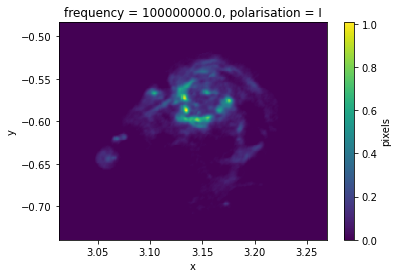

In [4]:
ximg2d["pixels"].plot.imshow()
plt.show()

Select I, V polarisations

In [5]:
print(ximg.sel({"polarisation": ["I", "V"]}))

# Apply a mask to the data
ximg = ximg.where(numpy.hypot(ximg["x"] - numpy.mean(ximg["x"]),
                              ximg["y"] - numpy.mean(ximg["y"])) < 0.03)

<xarray.Image>
Dimensions:       (frequency: 8, polarisation: 2, x: 256, y: 256)
Coordinates:
  * frequency     (frequency) float64 1e+08 1.014e+08 ... 1.086e+08 1.1e+08
  * polarisation  (polarisation) <U1 'I' 'V'
  * y             (y) float64 -0.7389 -0.7379 -0.7369 ... -0.4849 -0.4839
  * x             (x) float64 3.014 3.015 3.016 3.017 ... 3.267 3.268 3.269
    ra            (x, y) float64 3.315 3.313 3.312 3.311 ... 3.0 2.999 2.998
    dec           (x, y) float64 -0.7328 -0.7329 -0.733 ... -0.4783 -0.4782
Data variables:
    pixels        (frequency, polarisation, y, x) float64 0.0 0.0 ... 0.0 0.0
Attributes:
    rascil_data_model:    Image
    _polarisation_frame:  stokesIQUV
    _projection:          ('RA---SIN', 'DEC--SIN')
    spectral_type:        FREQ


In [6]:
print(ximg.sum())

<xarray.Dataset>
Dimensions:  ()
Data variables:
    pixels   float64 1.169e+04


Apply a function across the image in chunks using dask transparently

In [7]:
ximg["pixels"] = ximg["pixels"].chunk({"x": 32, "y": 32})
print(ximg)
ximg["pixels"] = xarray.apply_ufunc(numpy.sqrt, ximg["pixels"],
                               dask="parallelized",
                               output_dtypes=[float])

<xarray.Dataset>
Dimensions:       (frequency: 8, polarisation: 4, x: 256, y: 256)
Coordinates:
  * frequency     (frequency) float64 1e+08 1.014e+08 ... 1.086e+08 1.1e+08
  * polarisation  (polarisation) <U1 'I' 'Q' 'U' 'V'
  * y             (y) float64 -0.7389 -0.7379 -0.7369 ... -0.4849 -0.4839
  * x             (x) float64 3.014 3.015 3.016 3.017 ... 3.267 3.268 3.269
    ra            (x, y) float64 3.315 3.313 3.312 3.311 ... 3.0 2.999 2.998
    dec           (x, y) float64 -0.7328 -0.7329 -0.733 ... -0.4783 -0.4782
Data variables:
    pixels        (frequency, polarisation, y, x) float64 dask.array<chunksize=(8, 4, 32, 32), meta=np.ndarray>
Attributes:
    rascil_data_model:    Image
    _polarisation_frame:  stokesIQUV
    _projection:          ('RA---SIN', 'DEC--SIN')
    spectral_type:        FREQ


Show the resulting image

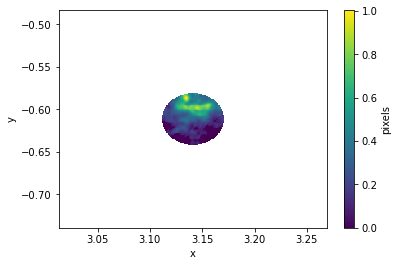

In [8]:
ximg["pixels"]= ximg["pixels"].sel({"frequency": frequency[0], "polarisation": "I"})
ximg["pixels"].plot.imshow()
plt.show()
